**Домашнее задание №1, Михалевич Максим Алексеевич, M4122**

Плланирую реалиовать модель для прогнозирования стоимости недвижимости, датасет был найден на Кагле и, на мой взгляд, не является популряным.

**Пункт 1)**
- бизнес постановка: Создать прогнозную модель для определения стоимости недвижимости
- ML-задача: Решить задачу регресии, так как целевая перменная (стоимость квартиры), не имеет четкой дискретизации
- Набор данных содержит 200.000 строк, а также 25 признаков, однако не все они являются релевантными задаче, что можно выявить при поверхностном анализе доменной области.

**Пункт 2)**
- В качестве метрики для оценки качества решения ML задачи планируется использовать MAPE (значений таргета в районе 0 в датасете не наблюдается, в силу исследуемой области, это обезопасит от деления на числа близкие к 0, что является слабым местом MAPE). Данная метрика имеет понятную для бизнеса интерпретацию, также она позволила бы потенциальному заказчику посторить некие доверительные интервалы, в которых может находиться прогноз модели, что, например, позволило бы с случае некоректного прогноза иметь заготовленные финансовые резервы для покрытия издержек в результате ошибочного прогноза.

Пункт 3) EDA
---



In [1]:
!pip install kagglehub phik sweetviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 56.2 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

import phik
import seaborn as sns
import sweetviz as sv
from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import kagglehub
from kagglehub import KaggleDatasetAdapter

In [3]:
file_path = 'global_house_purchase_dataset.csv'

data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mohankrishnathalla/global-house-purchase-decision-dataset",
  file_path
)

Using Colab cache for faster access to the 'global-house-purchase-decision-dataset' dataset.


In [4]:
data.head()

,property_id,country,city,property_type,furnishing_status,property_size_sqft,price,constructed_year,previous_owners,rooms,...,customer_salary,loan_amount,loan_tenure_years,monthly_expenses,down_payment,emi_to_income_ratio,satisfaction_score,neighbourhood_rating,connectivity_score,decision
0,1,France,Marseille,Farmhouse,Semi-Furnished,991,412935,1989,6,6,...,10745,193949,15,6545,218986,0.16,1,5,6,0
1,2,South Africa,Cape Town,Apartment,Semi-Furnished,1244,224538,1990,4,8,...,16970,181465,20,8605,43073,0.08,9,1,2,0
2,3,South Africa,Johannesburg,Farmhouse,Semi-Furnished,4152,745104,2019,5,2,...,21914,307953,30,2510,437151,0.09,6,8,1,0
3,4,Germany,Frankfurt,Farmhouse,Semi-Furnished,3714,1110959,2008,1,3,...,17980,674720,15,8805,436239,0.33,2,6,6,0
4,5,South Africa,Johannesburg,Townhouse,Fully-Furnished,531,99041,2007,6,3,...,17676,65833,25,8965,33208,0.03,3,3,4,0


In [6]:
data.columns

Index(['property_id', 'country', 'city', 'property_type', 'furnishing_status',
       'property_size_sqft', 'price', 'constructed_year', 'previous_owners',
       'rooms', 'bathrooms', 'garage', 'garden', 'crime_cases_reported',
       'legal_cases_on_property', 'customer_salary', 'loan_amount',
       'loan_tenure_years', 'monthly_expenses', 'down_payment',
       'emi_to_income_ratio', 'satisfaction_score', 'neighbourhood_rating',
       'connectivity_score', 'decision'],
      dtype='object')

In [7]:
data.shape

(200000, 25)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   property_id              200000 non-null  int64  
 1   country                  200000 non-null  object 
 2   city                     200000 non-null  object 
 3   property_type            200000 non-null  object 
 4   furnishing_status        200000 non-null  object 
 5   property_size_sqft       200000 non-null  int64  
 6   price                    200000 non-null  int64  
 7   constructed_year         200000 non-null  int64  
 8   previous_owners          200000 non-null  int64  
 9   rooms                    200000 non-null  int64  
 10  bathrooms                200000 non-null  int64  
 11  garage                   200000 non-null  int64  
 12  garden                   200000 non-null  int64  
 13  crime_cases_reported     200000 non-null  int64  
 14  lega

Из первичного анализа можно заключить, что в представленном наборе данных отсутвуют пропущенные значения, датасет содержит 200000 сэмлов и 25 признаков, также можно отменить наличие 4 категориальных признаков. Далее в ходе проведения EDA необоходимо будет рзаработать варианты их кодирования.

Для решения задачи прогнозирования стоимости жилья, логичным вариантом будет - принять признак price в качестве целевой переменной.
Также исследуемый датасет давольно обширен и обладает признаками, которые не будут иметь влияния на стоиомость жилья, так данный датасет направлен на решении задачи классификации успеха/неуспеха сделки купли продажи.

Справедливо будет на первом этапе исключить из рассмотрения следующие признаки, составляющие финансовый портрет потенциального клиента:
- customer_salary
- loan_amount
- loan_tenure_years
- monthly_expenses
- down_payment
- emi_to_income_ratio
- connectivity_score
- decision



In [9]:
df = data.copy()
columns_fro_drop = ['property_id',
                    'customer_salary',
                    'loan_amount',
                    'loan_tenure_years',
                    'monthly_expenses',
                    'down_payment',
                    'emi_to_income_ratio',
                    'connectivity_score',
                    'decision']
df = df.drop(columns=columns_fro_drop)
df.head()

,country,city,property_type,furnishing_status,property_size_sqft,price,constructed_year,previous_owners,rooms,bathrooms,garage,garden,crime_cases_reported,legal_cases_on_property,satisfaction_score,neighbourhood_rating
0,France,Marseille,Farmhouse,Semi-Furnished,991,412935,1989,6,6,2,1,1,1,0,1,5
1,South Africa,Cape Town,Apartment,Semi-Furnished,1244,224538,1990,4,8,8,1,1,1,1,9,1
2,South Africa,Johannesburg,Farmhouse,Semi-Furnished,4152,745104,2019,5,2,1,1,1,0,0,6,8
3,Germany,Frankfurt,Farmhouse,Semi-Furnished,3714,1110959,2008,1,3,3,0,1,0,0,2,6
4,South Africa,Johannesburg,Townhouse,Fully-Furnished,531,99041,2007,6,3,3,1,1,3,1,3,3


Анализ числовых признаков
-

In [13]:
num_cols = df.select_dtypes(exclude='object')
num_cols.describe()

,property_size_sqft,price,constructed_year,previous_owners,rooms,bathrooms,garage,garden,crime_cases_reported,legal_cases_on_property,satisfaction_score,neighbourhood_rating
count,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,3195.633460,1.215365e+06,1991.487770,3.001370,4.513855,2.760030,0.499350,0.500215,1.229065,0.248920,5.498650,5.505240
std,1613.322287,8.236633e+05,18.494064,2.002198,2.295669,1.840959,0.500001,0.500001,1.185336,0.432388,2.875361,2.870945
min,400.000000,5.628800e+04,1960.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1802.000000,5.659895e+05,1975.000000,1.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000
50%,3190.000000,1.023429e+06,1991.000000,3.000000,5.000000,2.000000,0.000000,1.000000,1.000000,0.000000,5.000000,5.000000
75%,4589.000000,1.725556e+06,2008.000000,5.000000,7.000000,4.000000,1.000000,1.000000,2.000000,0.000000,8.000000,8.000000
max,6000.000000,4.202732e+06,2023.000000,6.000000,8.000000,8.000000,1.000000,1.000000,10.000000,1.000000,10.000000,10.000000


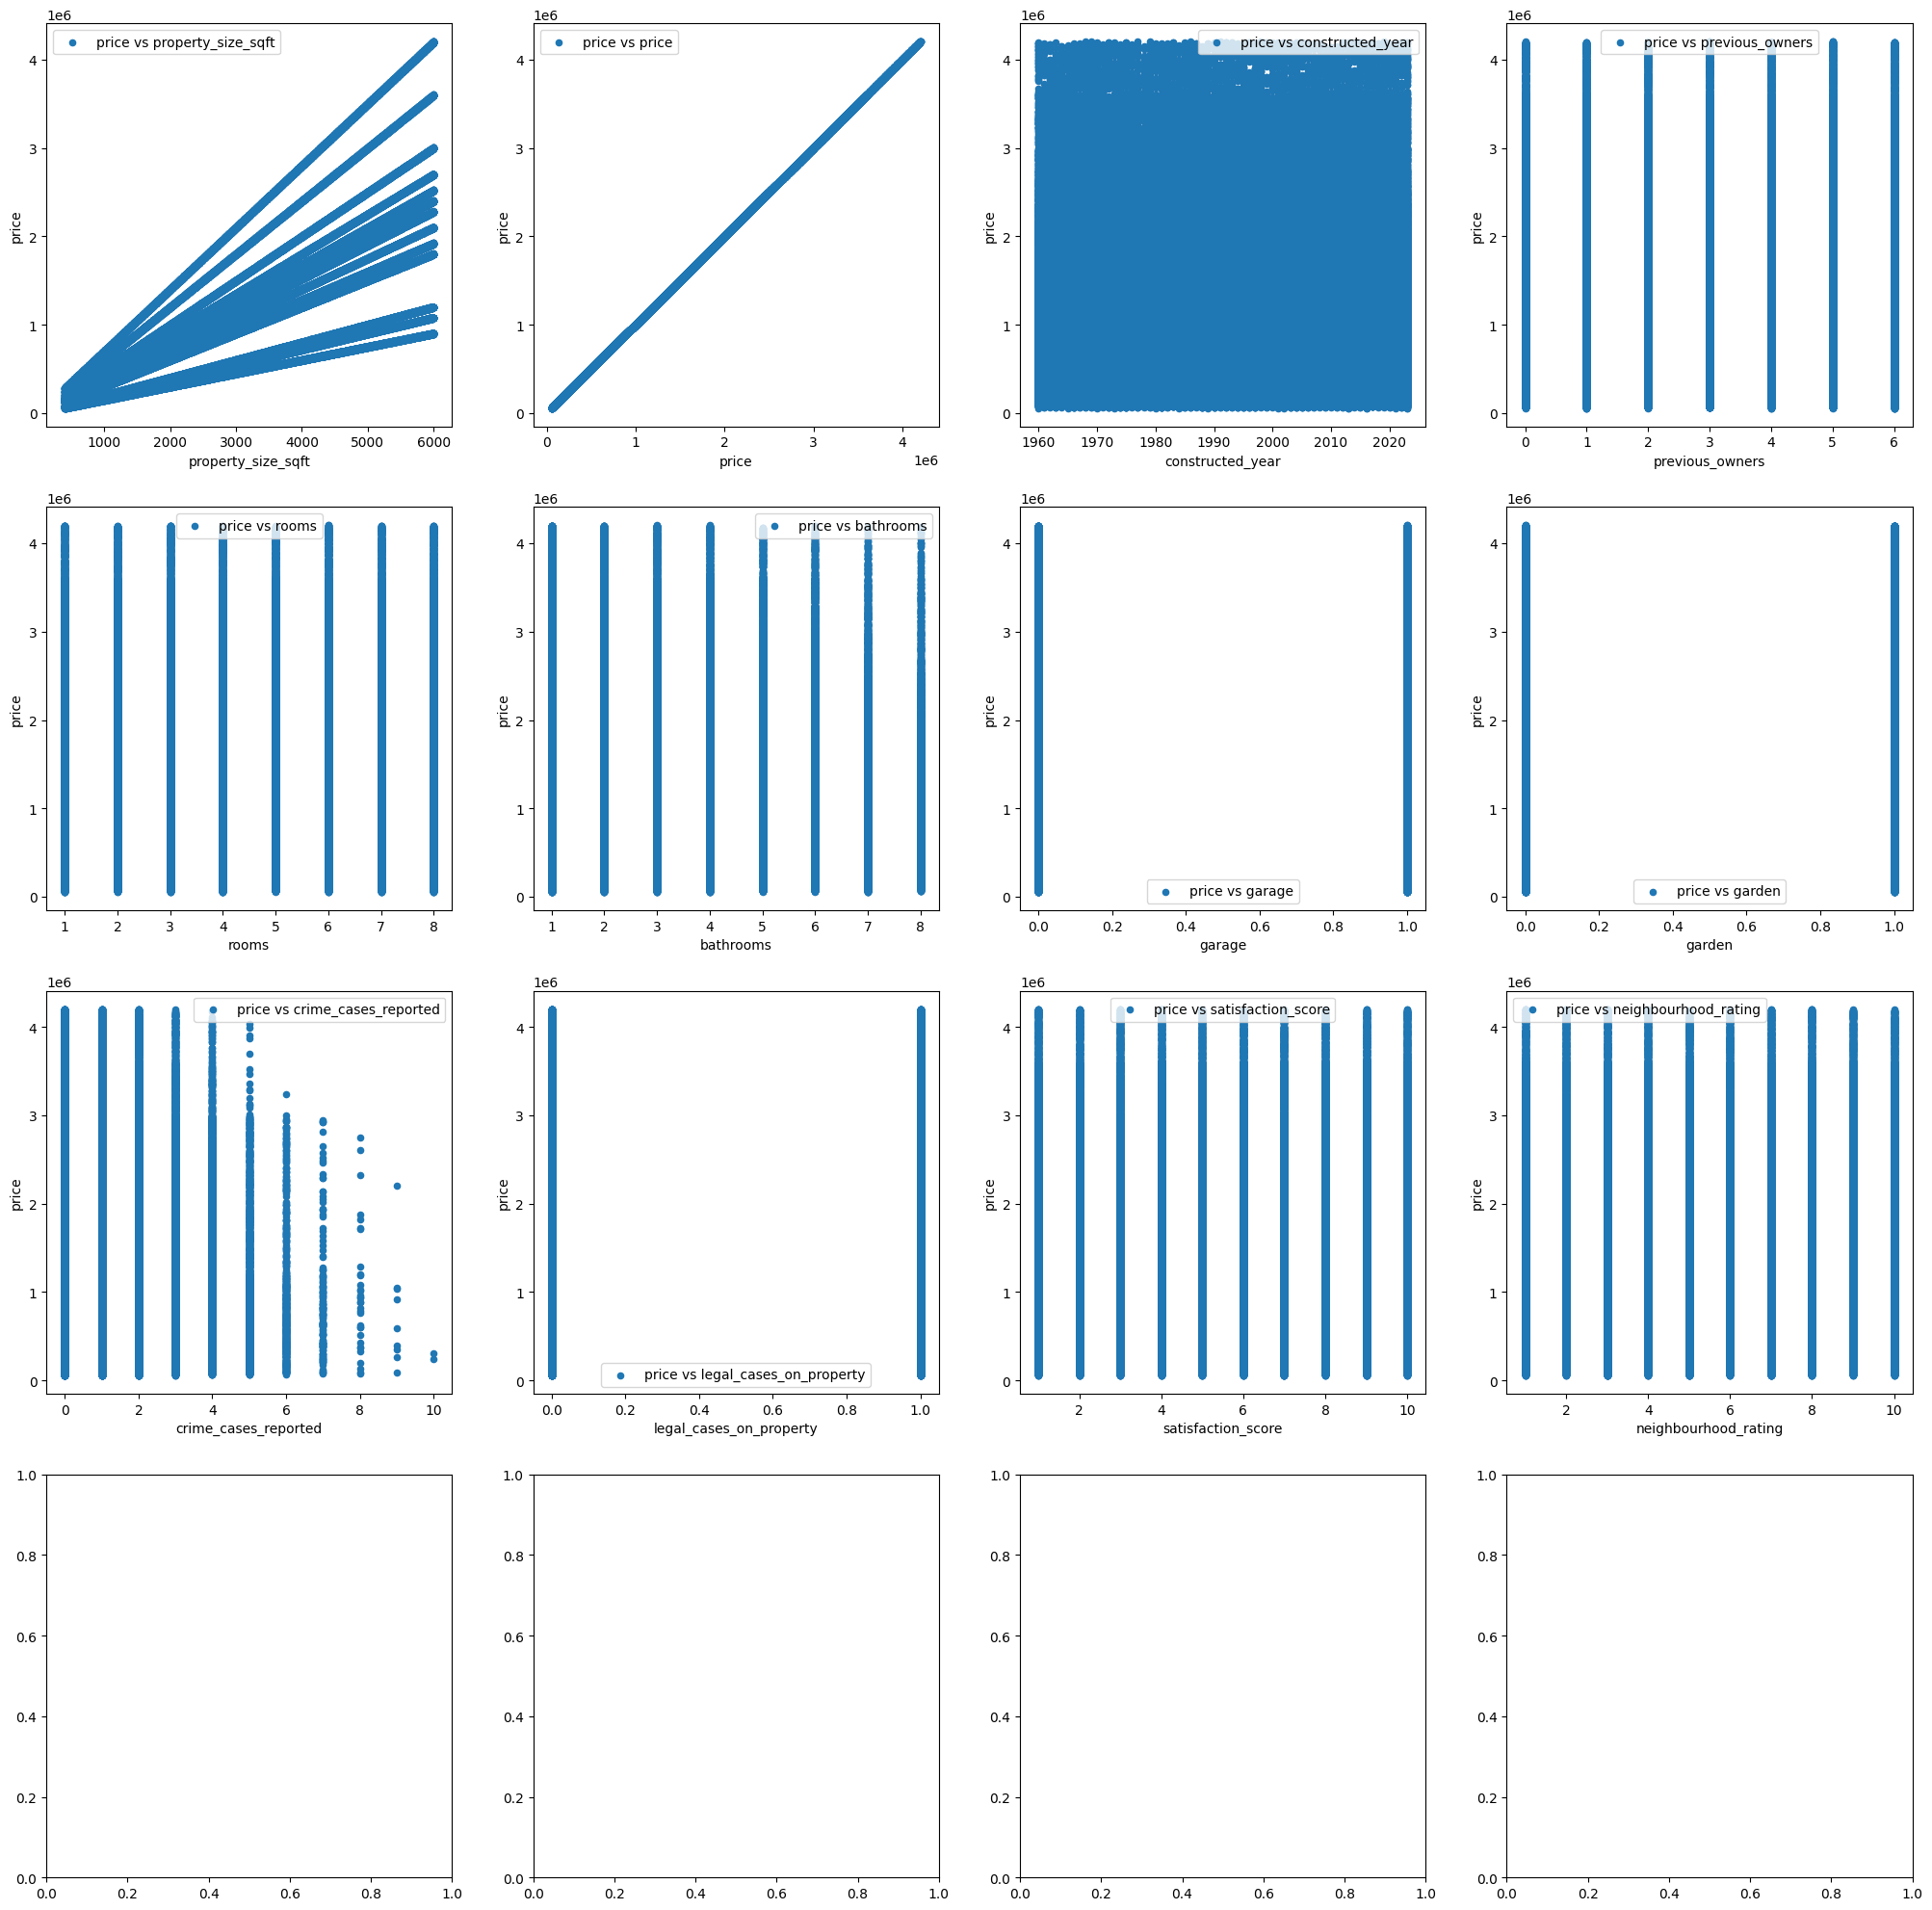

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 25))
for idx, feature in enumerate(num_cols.columns):
    df.plot(feature, "price", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4], label=f'price vs {feature}')

Считаем корреляцию числовых признаков по Пирсону, подтвержим наличие линейной связи признакака property_size_sqft с целевой переменной price и найдем силу этой связи. Также пронаблюдаем и зра другими признаками и их свящью с price

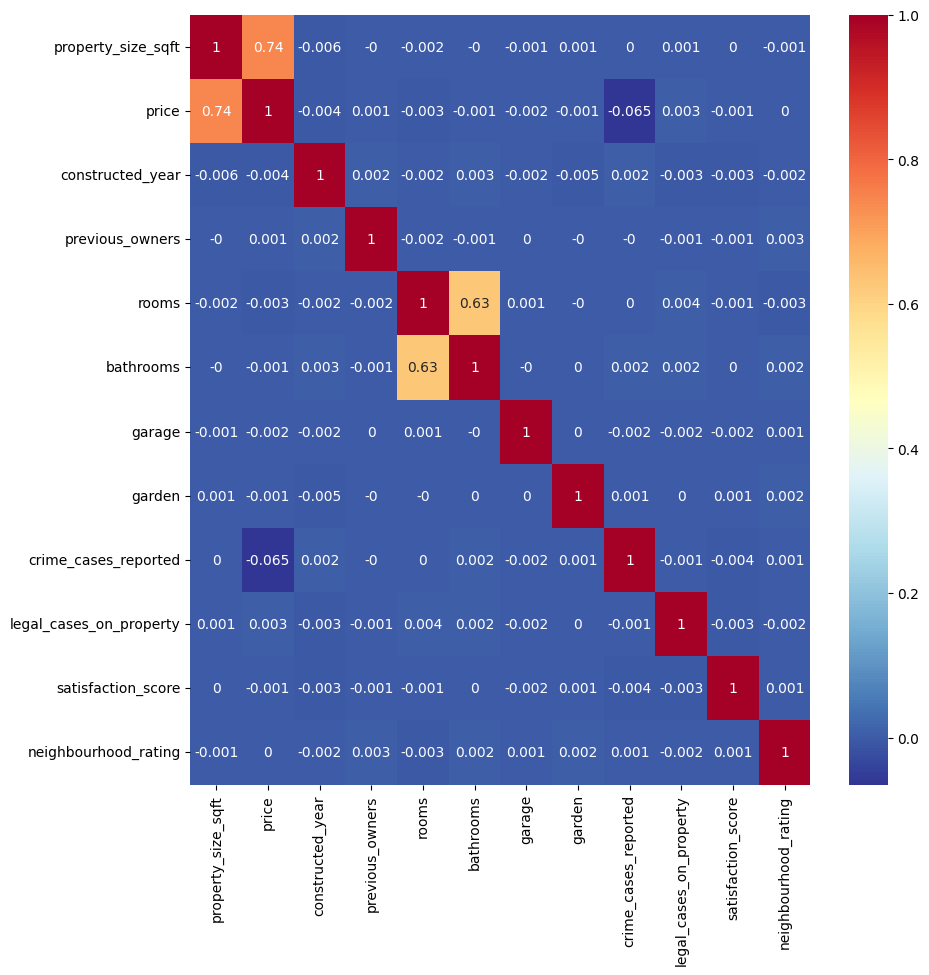

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(num_cols.corr().round(3), cmap="RdYlBu_r", annot=True);

Учтем и нелинейные зависимости, построив матрицу корреляций методом Спирмена

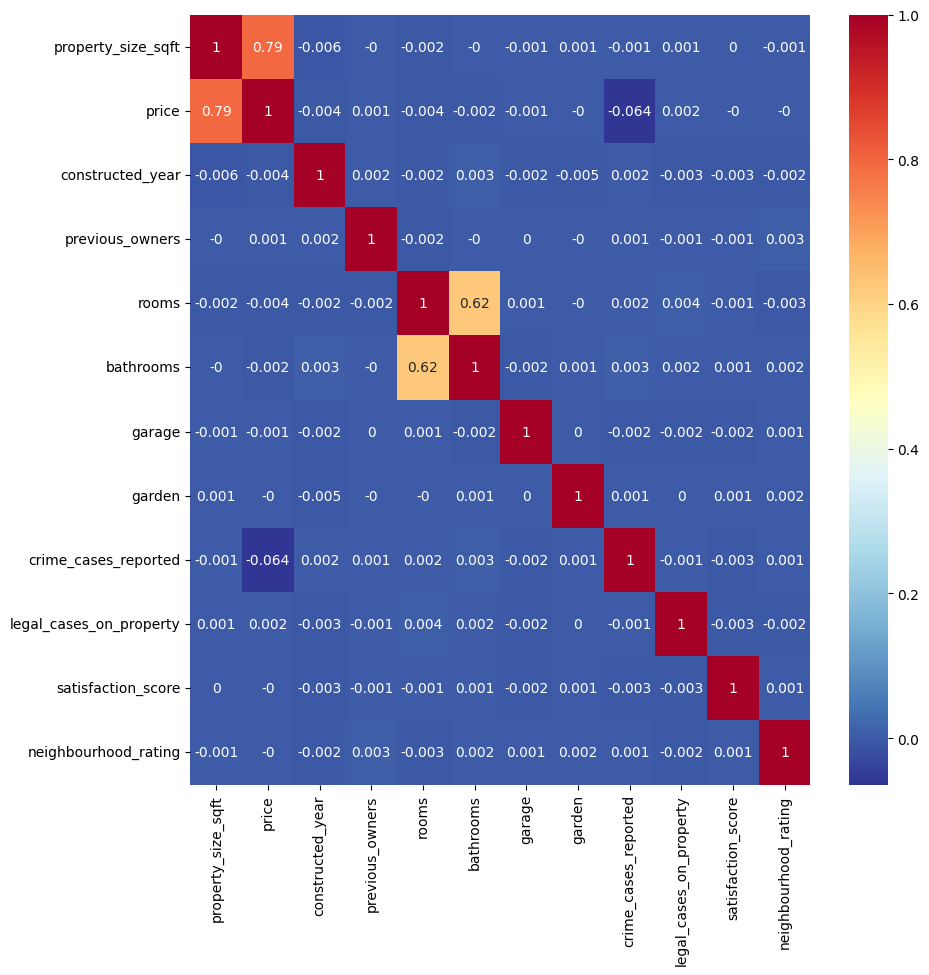

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(num_cols.corr(method='spearman').round(3), cmap="RdYlBu_r", annot=True);

Выводы по анализу числовых признаков: Анализ числовых фичей не дал серьезных резульатов. Удалось установить сильную линейную свзяь между целевой переменной и признаком площади жилья, значения корреляций составило 0,74 и 0,79 по методам Пирсона и Спирмена соответсвенно

Анализ категориальных признаков
-

In [12]:
cat_cols = df.select_dtypes(include='object')
cat_cols['price'] = df['price']
cat_cols.head()

,country,city,property_type,furnishing_status,price
0,France,Marseille,Farmhouse,Semi-Furnished,412935
1,South Africa,Cape Town,Apartment,Semi-Furnished,224538
2,South Africa,Johannesburg,Farmhouse,Semi-Furnished,745104
3,Germany,Frankfurt,Farmhouse,Semi-Furnished,1110959
4,South Africa,Johannesburg,Townhouse,Fully-Furnished,99041


Рассмострим изменяются ли средние значения и межкваритильные размахи целевой переменной в зависимости от страны, в которой находится недвижимость

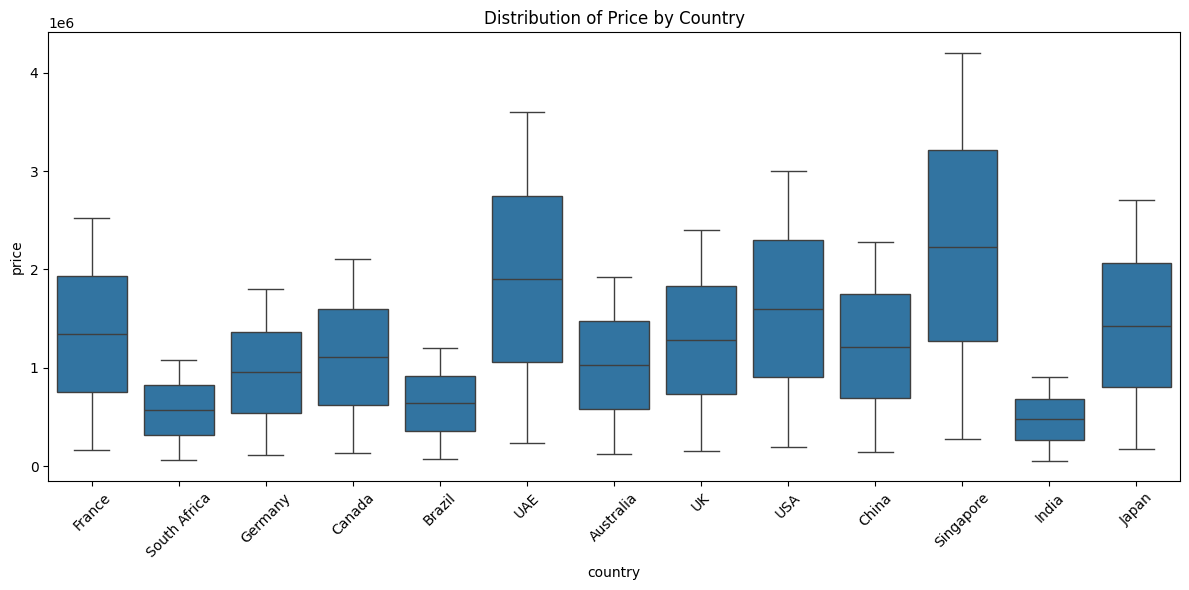

In [35]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=cat_cols, x='country', y='price')
plt.xticks(rotation=45)
plt.title('Distribution of Price by Country')
plt.tight_layout()
plt.show()

Можно заметить, что стоимость сильно зависит от страны, в которой находится недвижимость, теперь зафиксируем значение страны и оценим стат. характеристики переменной для различных городов.
Рассмотрим Францию

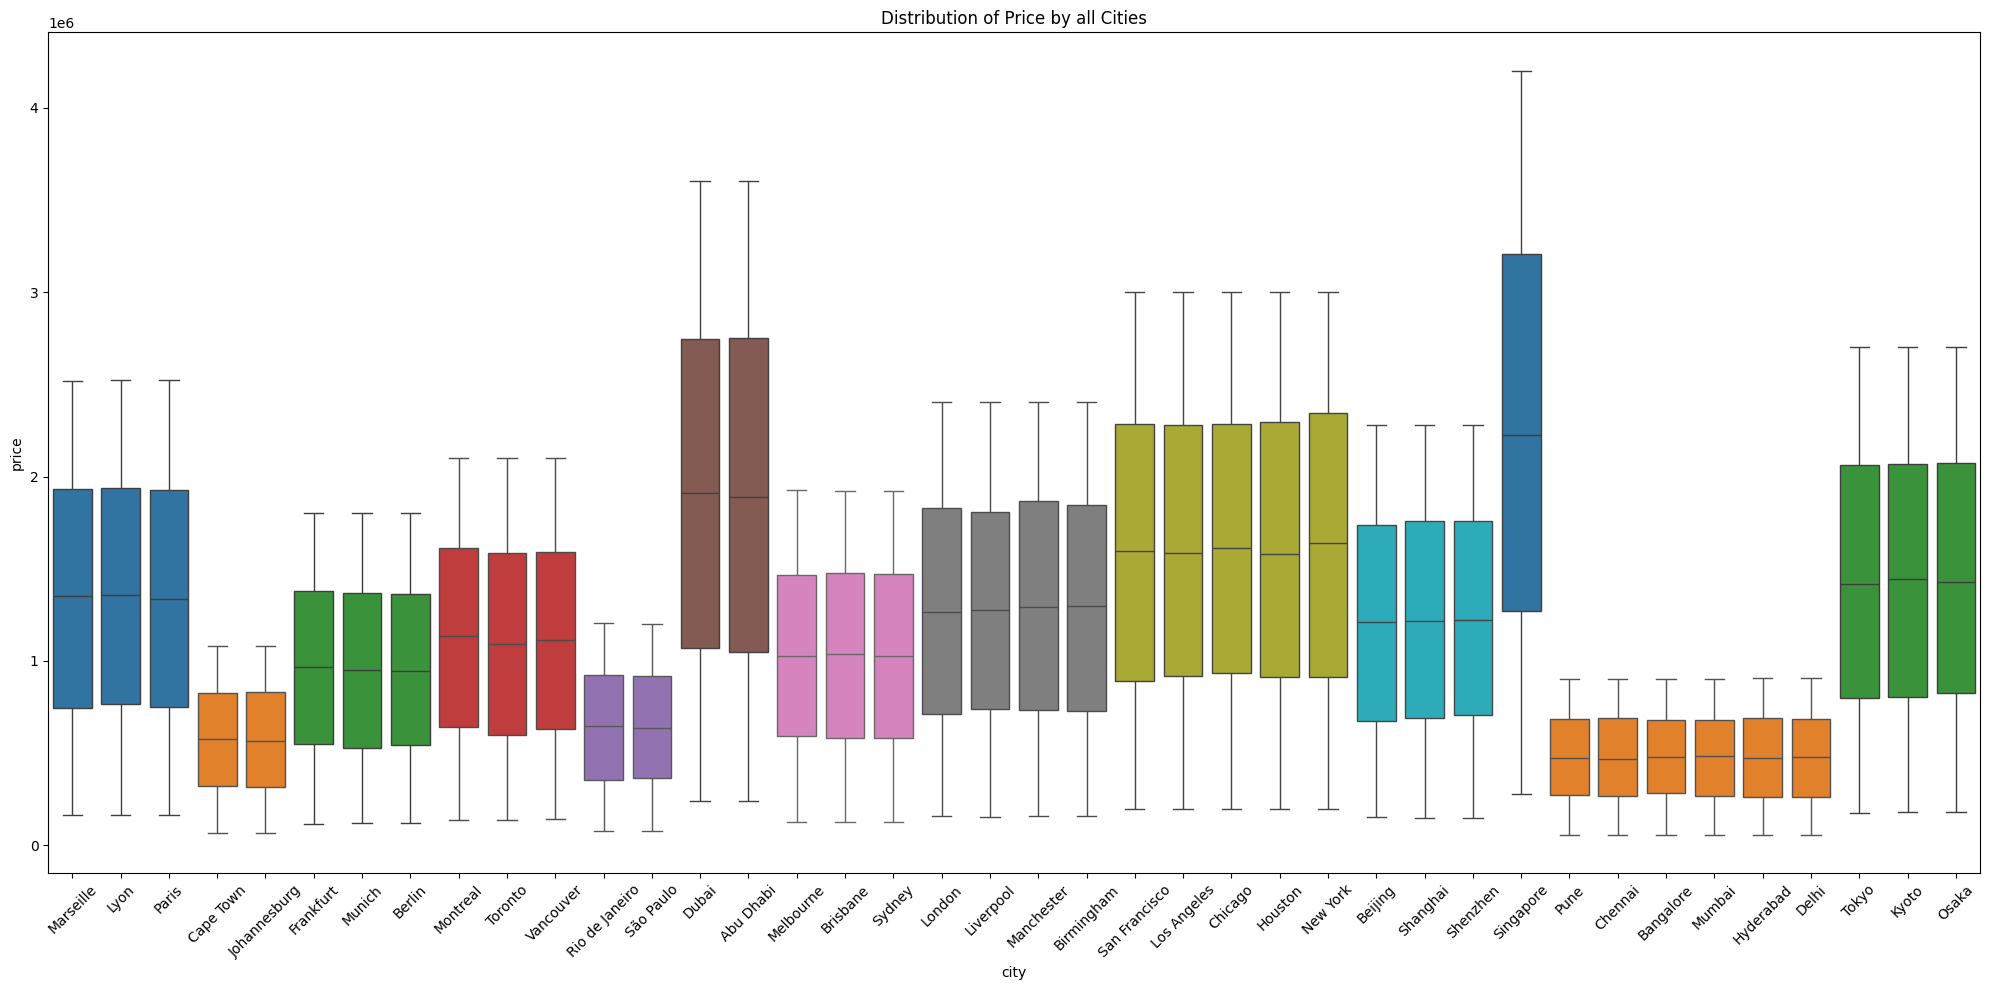

In [45]:
fig, axes = plt.subplots(figsize=(20, 10))
def box_for_city(country):
  sns.boxplot(data=cat_cols[cat_cols['country'] == country], x='city', y='price')
  plt.xticks(rotation=45)
  plt.title(f'Distribution of Price by all Cities')
  plt.tight_layout()


for elem in cat_cols['country'].unique():
  box_for_city(elem)
plt.show()

На визуализации каждый отдлельный цвет группирует одну страну из выборки
Можно заметить, что средние и межквартильные размахи незначительно отличаются в рамках одной страны, можем допустить, что один из признаков можно будет упустить из рассмотрения, однако для подобных решений нужна более детальная оценка

 Рассмотрим распределние значений переменной типа жилья и статус мебелировки, количественно в датасете классы каждого из типов сбалансированы. Также построим ящик с усами, что бы оценить средние и размахи каждой из групп

In [51]:
cat_cols['property_type'].value_counts()

,count
property_type,
Farmhouse,33518
Apartment,33398
Townhouse,33395
Villa,33347
Independent House,33334
Studio,33008


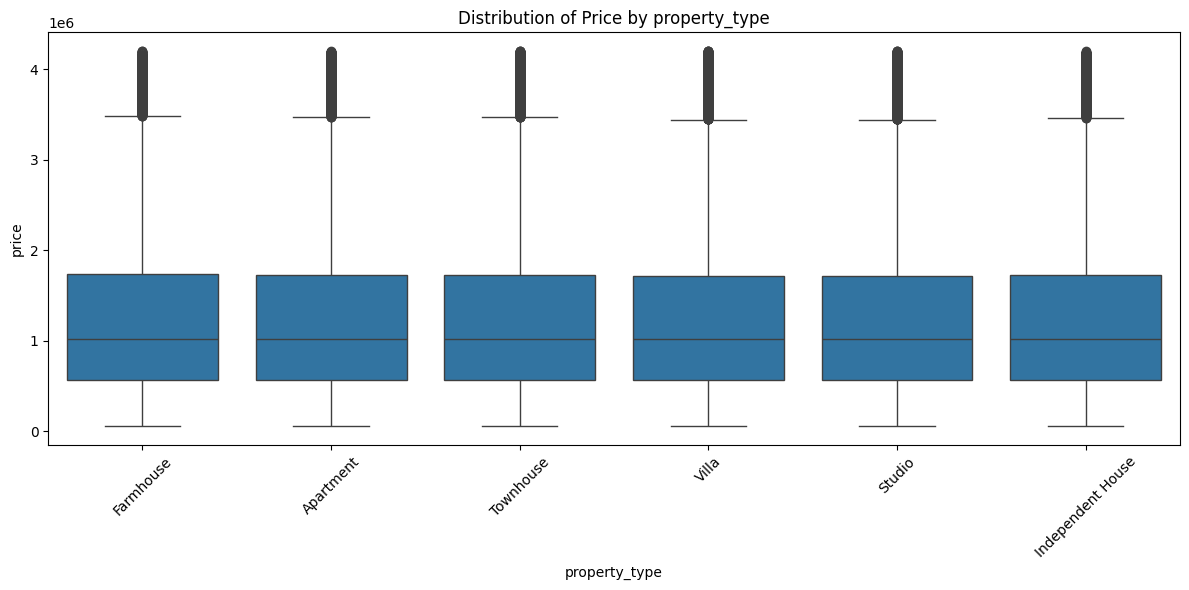

In [58]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=cat_cols, x='property_type', y='price')
plt.xticks(rotation=45)
plt.title('Distribution of Price by property_type')
plt.tight_layout()
plt.show()

In [57]:
cat_cols['furnishing_status'].value_counts()

,count
furnishing_status,
Fully-Furnished,66829
Semi-Furnished,66673
Unfurnished,66498


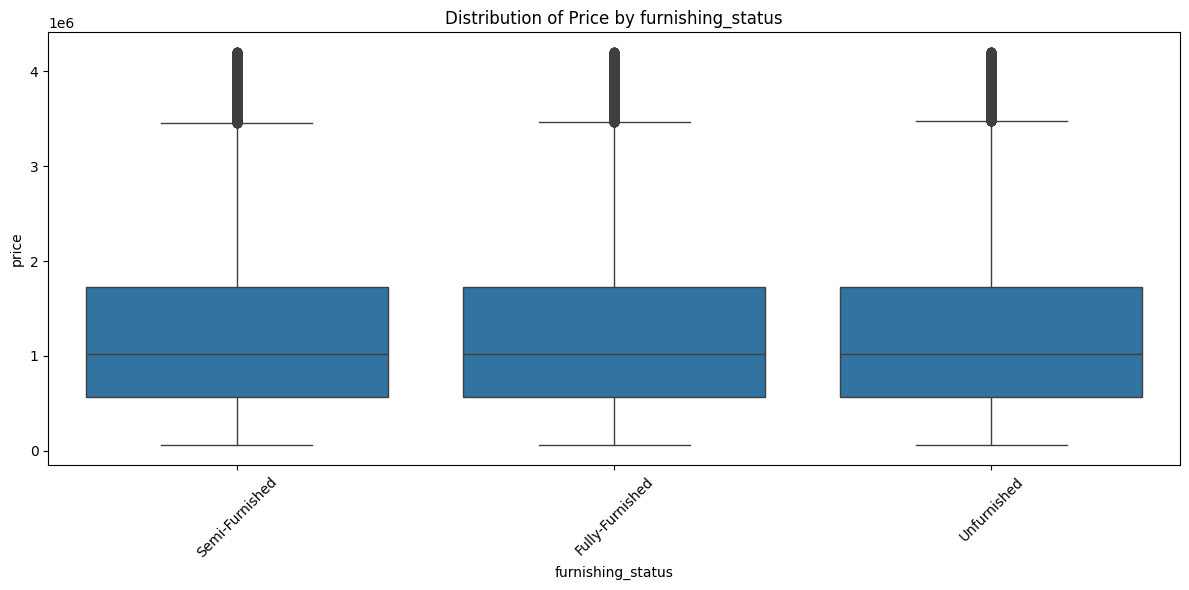

In [59]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=cat_cols, x='furnishing_status', y='price')
plt.xticks(rotation=45)
plt.title('Distribution of Price by furnishing_status')
plt.tight_layout()
plt.show()

Из анализа признаков типа жилья и статуса мебелировки можно заключить, что средние значения груп, межквартильные расстояние, а также выбросы в каждой из групп идентичны. Можно предположить, что кареляция этих признаков с целевой переменной будет также низкой.

Чтобы првоерить поставленные гипотезы о степени влияниия каждого категариального признака на целевую переменную price, а также чтобы выявить возможние мультиколлиниарности признаков проведем совместный анализ категориальных и числовых признаков методом PHIK

interval columns not set, guessing: ['property_size_sqft', 'price', 'constructed_year', 'previous_owners', 'rooms', 'bathrooms', 'garage', 'garden', 'crime_cases_reported', 'legal_cases_on_property', 'satisfaction_score', 'neighbourhood_rating']


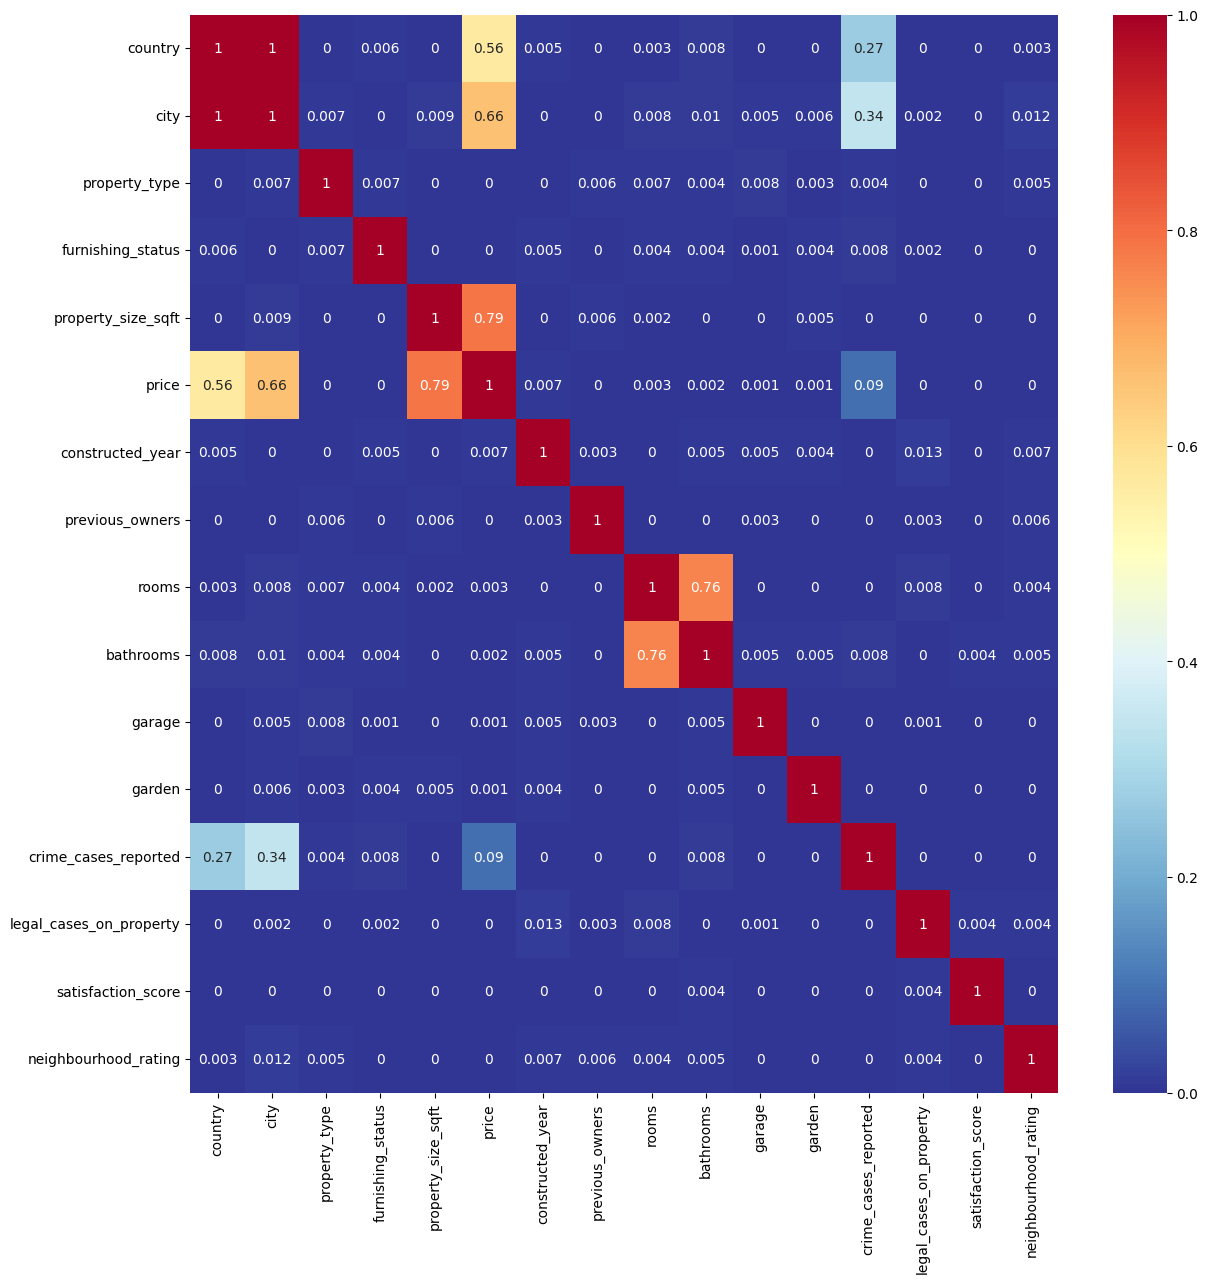

In [ ]:
plt.figure(figsize=(14, 14))
sns.heatmap(df.phik_matrix().round(3), cmap="RdYlBu_r", annot=True);

Выводы по проделанному EDA
---
- Как и ожидалось страны и города имеют единичную корриляцию между собой, необходимо выбрать один из этих признаков, более информативным является город. Так как данный признак более информативный в силу большей степени дискритизации. Также можно отметить, что признак city имеет все же большее влияния на целевую переменную, поэтому на данном этапе по результатам EDA анализа предлагается исключить из рассмотрения признак country
- Число комнат и число душевых также имееют сильную связь, что естественно
- Число криминальных случаев имеет чуть большее влияние на целевую переменную, что и предпалогалось при рассмотрении графиков зависимости переменной price от числовых признаков
